## Getting ERA5-Land monthly via Python API

In [1]:
import cdsapi
import timeit
import os
from utils import get_bbox
import xarray as xr
import zipfile
from matplotlib import pyplot as plt

# ERA5-Land Monthly Averaged Variables – Units Reference

This document summarizes the units for each variable available in the ERA5-Land **monthly_averaged_reanalysis** dataset via the CDS API.
> Check the [Documentation](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means?tab=overview)

---

### 📏 Units for ERA5-Land Monthly Averaged Variables

| Variable                         | Unit     | Description |
|----------------------------------|----------|-------------|
| **2m_temperature**               | Kelvin (K) | Air temperature at 2 meters above the surface. To convert to Celsius, subtract 273.15. |
| **total_precipitation**          | m/day    | Total precipitation accumulated over the day, expressed in meters of water equivalent per day. Multiply by 1000 to convert to mm/day. Multiply by the number of days in the month for total monthly precipitation. |
| **surface_runoff**               | m/day    | Surface runoff accumulated over the day, in meters of water equivalent. Multiply by 1000 for mm/day. Multiply by number of days in the month for monthly total. |
| **snow_depth_water_equivalent**  | m        | Instantaneous depth of snow in meters of water equivalent. |
| **potential_evaporation**        | m/day    | Potential evaporation per day in meters. Multiply by 1000 for mm/day. Multiply by number of days in the month for monthly total. |
| **total_evaporation**            | m/day    | Actual evapotranspiration per day in meters. Multiply by 1000 for mm/day. Multiply by number of days in the month for monthly total. |

---

### 🔄 Notes on Data Interpretation

- **Accumulated Variables**:
    - Values are **daily means in meters/day**.
    - To compute **total for a month**:
      `monthly_total = daily_mean × number_of_days_in_month`
    - Example:
      `0.004 m/day × 30 days = 0.12 m`

- **Instantaneous Variables**:
    - Do **not** need accumulation over time.

---

> For more details, refer to the [ERA5-Land documentation](https://confluence.ecmwf.int/display/CKB/ERA5-Land:+data+documentation).

### User Input

In [2]:
ISO_A2 = 'GN'

start_year = 2000                                            # from 1950
end_year = 2002

variables_list = ['2m_temperature',
                  'total_precipitation',
                  'surface_runoff',
                  'snow_depth_water_equivalent',
                  'potential_evaporation',
                  'total_evaporation'
                 ]# to present year

folder_nc = 'output'

### Processing Data

In [3]:
dataset = 'reanalysis-era5-land-monthly-means'# 'reanalysis-era5-land'
variable_name = {
    'total_precipitation': 'tp',
    'surface_runoff': 'sro',
    'snow_depth_water_equivalent': 'sd',
    '2m_temperature': 't2m',
    'potential_evaporation': 'pev',
    'total_evaporation': 'e'
}

temp = '_'.join([variable_name[variable] for variable in variables_list])
downloaded_file = f'{ISO_A2}_{start_year}_{end_year}_monthly_{temp}.zip'
print(f'Downloaded file is {downloaded_file}')

long_west, lat_south, long_east, lat_north = get_bbox(ISO_A2)

Downloaded file is GN_2000_2002_monthly_t2m_tp_sro_sd_pev_e.zip


### API Climate Data Store

In [4]:
years = [ str(start_year +i ) for i in range(end_year - start_year + 1)]
if not os.path.exists(folder_nc): os.mkdir(folder_nc)
downloaded_file = os.path.join(folder_nc, downloaded_file)

print('Process started. Please wait the ending message ... ')
start = timeit.default_timer()
c = cdsapi.Client()

c.retrieve(
    dataset,
    {
        'format': 'netcdf',
        #'format': 'grib',
        'product_type': 'monthly_averaged_reanalysis',
        'variable': variables_list,
        'year': years,
        'month': [ '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12' ],
        'time': '00:00',
        'area': [ lat_south, long_west, lat_north, long_east ],
    }, downloaded_file
    )

stop = timeit.default_timer()
print('Process completed in ', (stop - start)/60, ' minutes')

Process started. Please wait the ending message ... 


2025-04-15 17:36:58,340 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-15 17:36:58,341 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-15 17:36:58,545 INFO Request ID is 67d48602-a52f-4574-b66f-f3f100fd7062
2025-04-15 17:36:58,852 INFO status has been updated to accepted
2025-04-15 17:37:12,832 INFO status has been updated to running
2025-04-15 17:38:15,091 INFO status has been updated to successful
                                                                                          

Process completed in  1.2912579430655267  minutes


## Extracting Data from file
### Understanding `stepType`: Handling Instantaneous vs Accumulated Variables in ERA5-Land Monthly Averages

In ERA5-Land monthly reanalysis data, variables are processed differently depending on whether they are **instantaneous** or **accumulated**. This affects how they are averaged and stored in GRIB files.

---

#### 🔄 Key `stepType` Values

| `stepType` | Meaning |
|------------|---------|
| **`avgid`** | Monthly **average of hourly data** that was originally **instantaneous** (e.g., 2m temperature). |
| **`avgas`** | Monthly **average of hourly data** that was originally **accumulated**, then **scaled** to a rate (e.g., total precipitation → precipitation rate → monthly average). |

---

#### 🧠 Why It Matters

- These different `stepType`s **must be handled separately** when reading GRIB files using tools like `cfgrib`.
- Attempting to read a GRIB file with mixed `stepType`s without filtering will cause errors.

---

#### ✅ How to Extract Data

Use `cfgrib` with `filter_by_keys` to open each type separately:

```python
import xarray as xr

# For instantaneous variables (e.g., 2m_temperature)
ds_instant = xr.open_dataset("data.grib", engine="cfgrib",
                             backend_kwargs={"filter_by_keys": {"stepType": "avgid"}})

# For accumulated variables (e.g., total_precipitation)
ds_accum = xr.open_dataset("data.grib", engine="cfgrib",
                           backend_kwargs={"filter_by_keys": {"stepType": "avgas"}})
```

You can then merge the datasets if they share compatible dimensions.

---

> For more, see the [CDS GRIB-to-netCDF changes](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation).

In [5]:
def extract_data(zip_path):

    # extract files from zip file
    extract_to = 'extracted_files'
    # Extract all files
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    # Loop through extracted files and open GRIB files
    for root, dirs, files in os.walk(extract_to):
        for file in files:
            if file.endswith('.grib') or file.endswith('.grb'):
                grib_path = os.path.join(root, file)
                print(f"Opening GRIB file: {grib_path}")
                try:
                    ds_avgid = xr.open_dataset(grib_path, engine='cfgrib',
                                               backend_kwargs={"filter_by_keys": {"stepType": "avgid"}},
                                               decode_timedelta=True)
                    ds_avgas = xr.open_dataset(grib_path, engine="cfgrib",
                                               backend_kwargs={"filter_by_keys": {"stepType": "avgas"}},
                                               decode_timedelta=True)
                    dataset = xr.merge([ds_avgid, ds_avgas])

                    print(dataset)  # or process the dataset as needed
                except Exception as e:
                    print(f"Failed to open {file}: {e}")
    return dataset


ds_raw = extract_data(downloaded_file)


Opening GRIB file: extracted_files/data.grib
<xarray.Dataset> Size: 3MB
Dimensions:     (time: 36, latitude: 55, longitude: 75)
Coordinates:
  * time        (time) datetime64[ns] 288B 2000-01-01 2000-02-01 ... 2002-12-01
  * latitude    (latitude) float64 440B 12.59 12.49 12.39 ... 7.391 7.291 7.19
  * longitude   (longitude) float64 600B -15.08 -14.98 -14.88 ... -7.781 -7.681
    number      int64 8B 0
    step        timedelta64[ns] 8B 1 days
    surface     float64 8B 0.0
    valid_time  (time) datetime64[ns] 288B 2000-01-02 2000-02-02 ... 2002-12-02
Data variables:
    t2m         (time, latitude, longitude) float32 594kB ...
    tp          (time, latitude, longitude) float32 594kB 5.619e-06 ... nan
    sro         (time, latitude, longitude) float32 594kB 1.717e-08 ... nan
    pev         (time, latitude, longitude) float32 594kB -0.01173 ... nan
    e           (time, latitude, longitude) float32 594kB -0.001652 ... nan
Attributes:
    GRIB_edition:            1
    GRIB_centre:

### Unit Conversion

In [6]:
def convert_dataset_units(ds):
    """
    Convert ERA5-Land variables in a Dataset to commonly used units,
    and export a Markdown table with the conversion details.

    Parameters:
        ds (xarray.Dataset): The input dataset with ERA5-Land variables.
        output_md_path (str): File path to save the Markdown table.

    Returns:
        ds_converted (xarray.Dataset): Dataset with converted units.
        output_md_path (str): Path to the Markdown file.
    """
    conversions = {
        "t2m": {"description": "2m temperature", "original_unit": "K", "factor": 1, "offset": -273.15, "new_unit": "degC"},
        "tp": {"description": "Total precipitation", "original_unit": "m/day", "factor": 1000, "offset": 0, "new_unit": "mm/day"},
        "sro": {"description": "Surface runoff", "original_unit": "m/day", "factor": 1000, "offset": 0, "new_unit": "mm/day"},
        "pev": {"description": "Potential evaporation", "original_unit": "m/day", "factor": 1000, "offset": 0, "new_unit": "mm/day"},
        "e": {"description": "Total evaporation", "original_unit": "m/day", "factor": 1000, "offset": 0, "new_unit": "mm/day"},
        "sd": {"description": "Snow depth water equivalent", "original_unit": "m", "factor": 1000, "offset": 0, "new_unit": "mm"}
    }

    ds_converted = ds.copy()
    for var, conv in conversions.items():
        if var in ds_converted.data_vars:
            ds_converted[var] = ds_converted[var] * conv["factor"] + conv["offset"]
            ds_converted[var].attrs["units"] = conv["new_unit"]
    return ds_converted

ds = convert_dataset_units(ds_raw)

In [7]:
print(ds)

<xarray.Dataset> Size: 3MB
Dimensions:     (time: 36, latitude: 55, longitude: 75)
Coordinates:
  * time        (time) datetime64[ns] 288B 2000-01-01 2000-02-01 ... 2002-12-01
  * latitude    (latitude) float64 440B 12.59 12.49 12.39 ... 7.391 7.291 7.19
  * longitude   (longitude) float64 600B -15.08 -14.98 -14.88 ... -7.781 -7.681
    number      int64 8B 0
    step        timedelta64[ns] 8B 1 days
    surface     float64 8B 0.0
    valid_time  (time) datetime64[ns] 288B 2000-01-02 2000-02-02 ... 2002-12-02
Data variables:
    t2m         (time, latitude, longitude) float32 594kB 26.97 27.05 ... 25.45
    tp          (time, latitude, longitude) float32 594kB 0.005619 ... nan
    sro         (time, latitude, longitude) float32 594kB 1.717e-05 ... nan
    pev         (time, latitude, longitude) float32 594kB -11.73 -11.77 ... nan
    e           (time, latitude, longitude) float32 594kB -1.652 -1.619 ... nan
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
 

## Data Visualizaiton

In [8]:


def plot_mean_map(ds, var):
    mean_field = ds[var].mean(dim='time')
    plt.figure(figsize=(8, 6))
    mean_field.plot()
    plt.title(f"Mean {var.upper()} Over Time")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


def plot_monthly_climatology_grid(ds, var):
    # Group by month and average over years
    monthly_clim = ds[var].groupby('time.month').mean(dim='time')

    fig, axes = plt.subplots(3, 4, figsize=(16, 10), constrained_layout=True)
    axes = axes.flatten()

    for i in range(12):
        ax = axes[i]
        monthly_clim.sel(month=i+1).plot(ax=ax, add_colorbar=False)
        ax.set_title(f"{var.upper()} - Month {i+1}")
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Add a single colorbar on the side
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    im = monthly_clim.sel(month=1).plot(ax=axes[0], add_colorbar=False)
    fig.colorbar(im, cax=cbar_ax, label=ds[var].attrs.get('units', var))

    plt.suptitle(f"Interannual Monthly Mean of {var.upper()}", fontsize=16)
    plt.show()

def plot_spatial_mean_timeseries_all_vars(ds):
    plt.figure(figsize=(12, 6))

    for var in ds.data_vars:
        # Calculate spatial average over lat/lon
        spatial_mean = ds[var].mean(dim=['latitude', 'longitude'])

        # Plot it
        plt.plot(ds.time, spatial_mean, label=var.upper())

    plt.title("Spatial Mean Time Series for All Variables")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


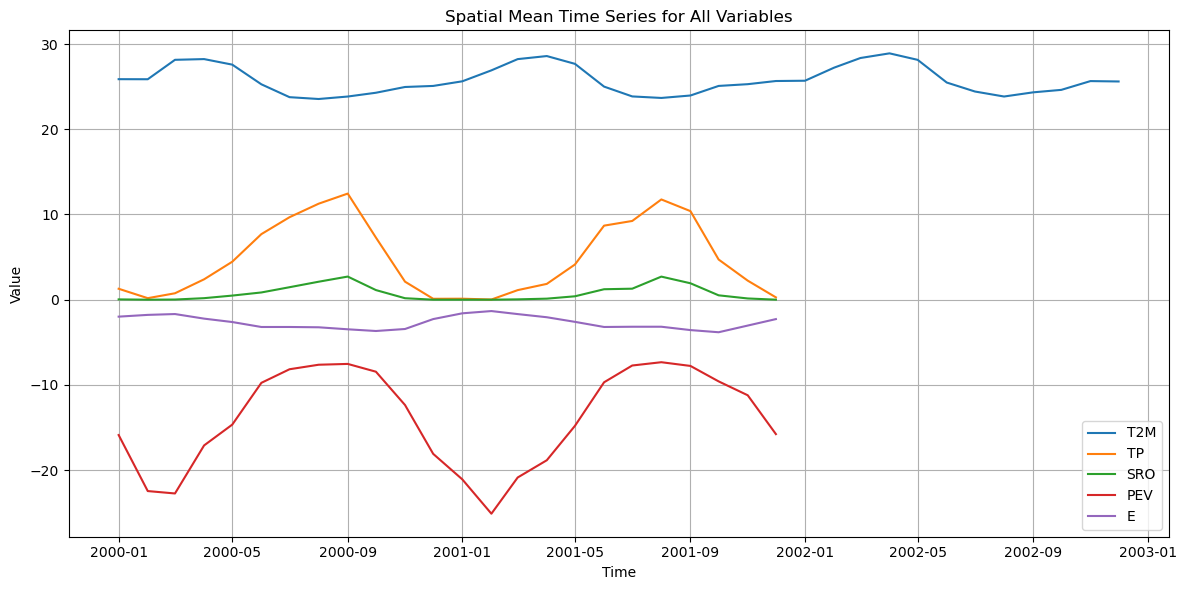

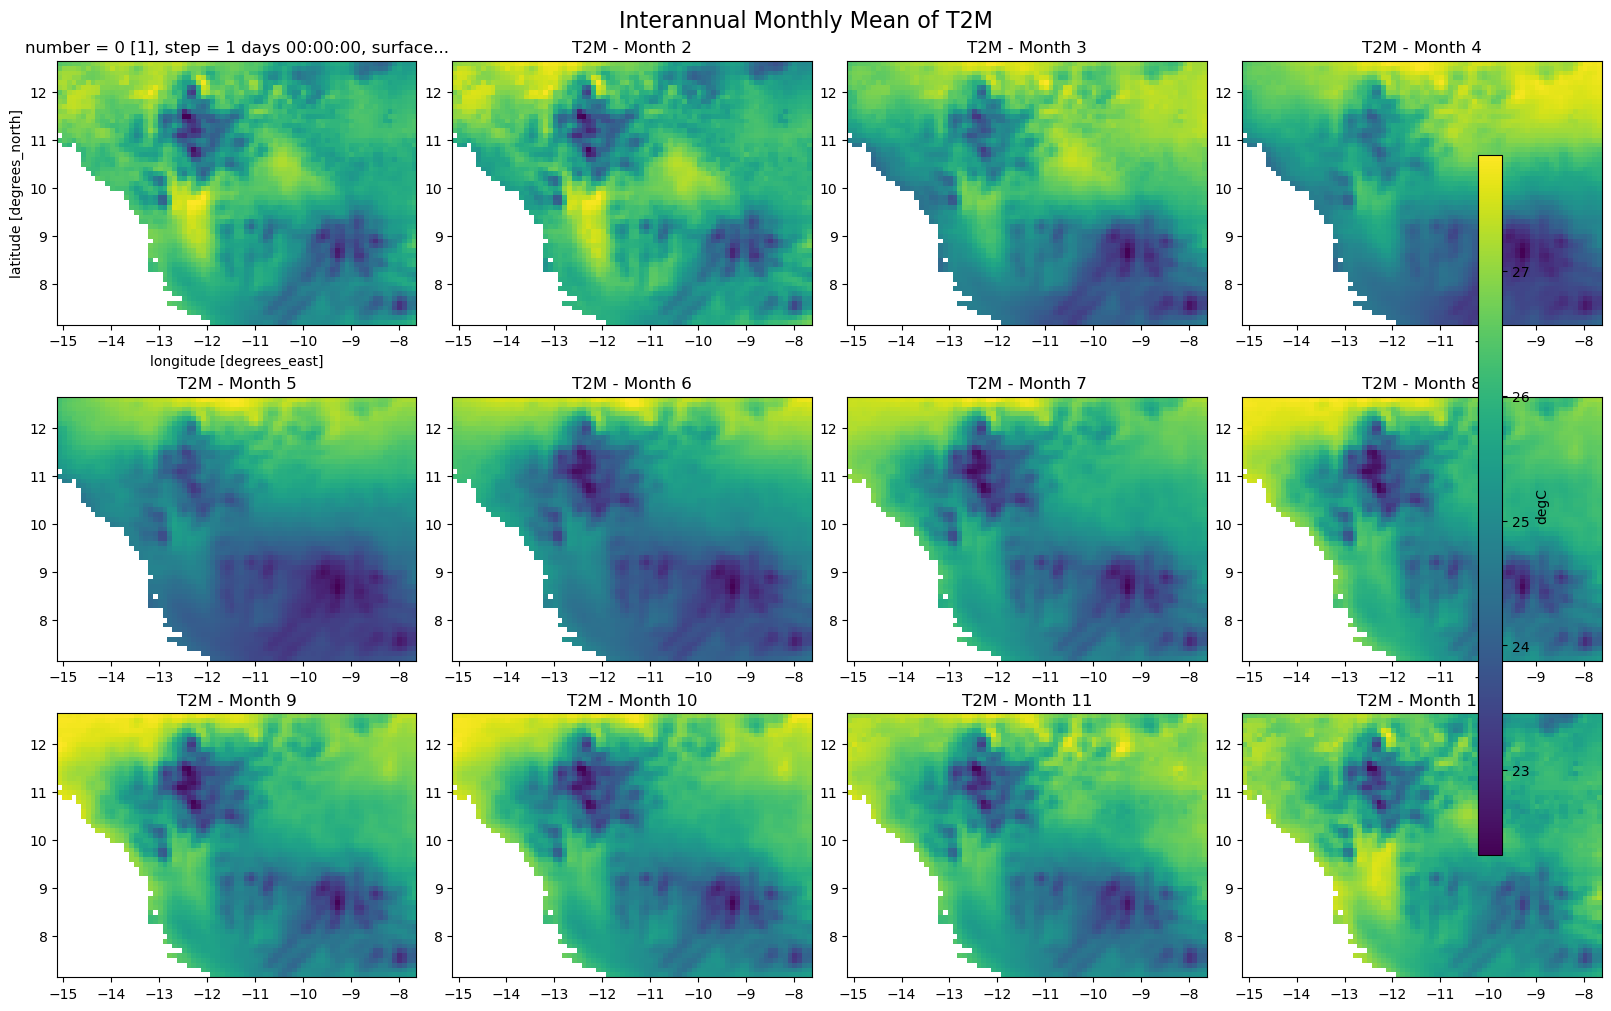

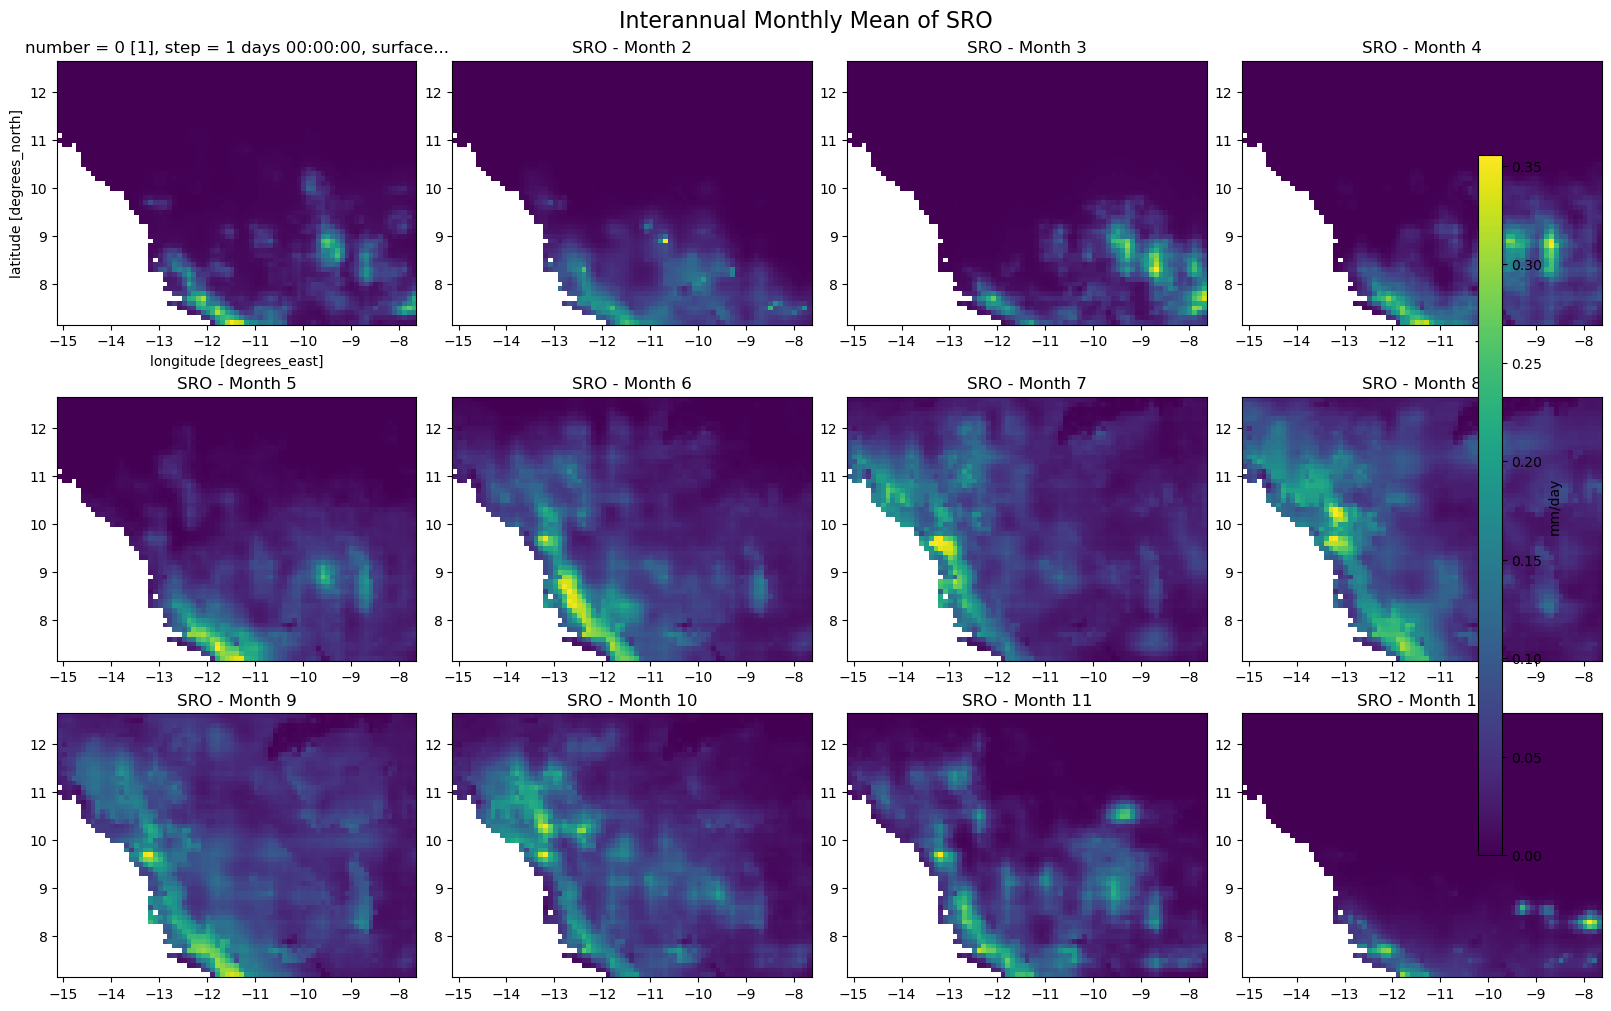

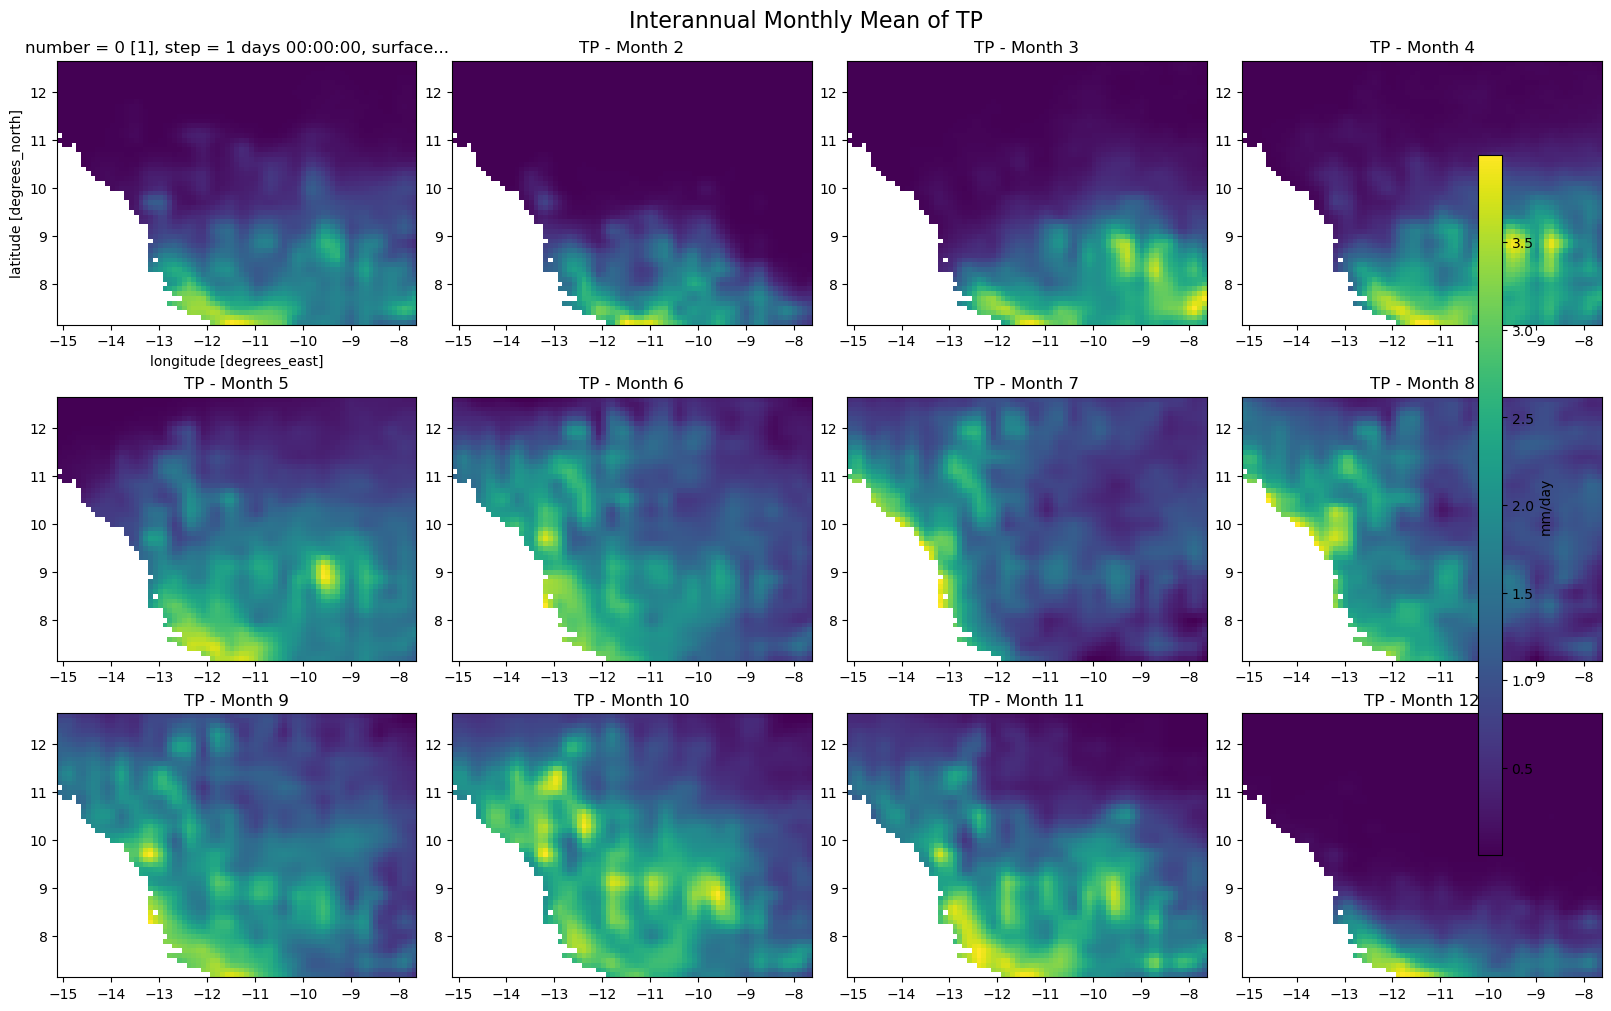

In [9]:
plot_spatial_mean_timeseries_all_vars(ds)
plot_monthly_climatology_grid(ds, "t2m")
plot_monthly_climatology_grid(ds, "sro")
plot_monthly_climatology_grid(ds, "tp")